With RSI:
* CRM - Done
* MCD - Done
* WBA - Done
* VZ - Done
* V - Done
* UNH - Done
* TRV - Done
* PG - Done
* MSFT - Done
* MRK - Done
* MMM - Done
* KO - Done
* CSCO - Done
* JPM -
* JNJ - Done
* INTC - Done
* IBM - Done
* HON - Done
* HD - Done
* GS - Done
* DOW - Done
* CVX - Done
* WMT - Done

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import requests
import pandas as pd

# API Key for Alpha Vantage (replace with your own)
ALPHA_VANTAGE_API_KEY = "Y0H7RZ2X1RDAWK73"

def fetch_and_modify_stock_data(stock_name, filename="stock_data_modified.csv"):
    """
    Fetches stock data from Alpha Vantage, modifies it by:
    1. Adding a `stock_id` column.
    2. Renaming the `5. volume` column to `volume`.
    3. Saving the modified data to a CSV file.

    Parameters:
        stock_name (str): Stock symbol (e.g., "AAPL", "GOOGL").
        filename (str): Name of the CSV file to save the modified data.

    Returns:
        None
    """
    # API Endpoint and Parameters
    base_url = "https://www.alphavantage.co/query"
    params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": stock_name,
        "apikey": ALPHA_VANTAGE_API_KEY,
        "outputsize": "compact"
    }

    # API Request
    response = requests.get(base_url, params=params)
    data = response.json()

    # Extract the time series data
    time_series = data.get("Time Series (Daily)", {})
    if not time_series:
        raise ValueError("Failed to fetch stock data. Check the stock symbol or API key.")

    # Convert JSON data to DataFrame
    df = pd.DataFrame.from_dict(time_series, orient="index")
    df = df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. volume": "volume"  # Rename volume column
    })

    # Convert all columns to numeric and sort by date
    df = df.astype(float)
    df.index = pd.to_datetime(df.index)  # Convert index to datetime
    df = df.sort_index(ascending=True)

    # Add stock_id column
    df["stock_id"] = stock_name

    # Save the modified DataFrame to a CSV file
    df.tail(60).to_csv(filename, index_label="date")
    print(f"Stock data for {stock_name} saved to {filename}")

# Example Usage
if __name__ == "__main__":
    stock_name = "JPM"  # Replace with the desired stock symbol
    fetch_and_modify_stock_data(stock_name, "JPM_Stock_Data.csv")

Stock data for JPM saved to JPM_Stock_Data.csv


In [ ]:
import requests
import pandas as pd

# API Key for Alpha Vantage (replace with your own)
ALPHA_VANTAGE_API_KEY = "Y0H7RZ2X1RDAWK73"

def fetch_and_modify_stock_data(stock_name, filename="stock_data_with_rsi.csv"):
    """
    Fetches stock data from Alpha Vantage, modifies it by:
    1. Adding a `stock_id` column.
    2. Renaming the `5. volume` column to `volume`.
    3. Fetching and adding RSI data.
    4. Saving the modified data to a CSV file.

    Parameters:
        stock_name (str): Stock symbol (e.g., "AAPL", "GOOGL").
        filename (str): Name of the CSV file to save the modified data.

    Returns:
        None
    """
    # API Endpoint and Parameters for Stock Data (Time Series Daily)
    base_url = "https://www.alphavantage.co/query"
    params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": stock_name,
        "apikey": ALPHA_VANTAGE_API_KEY,
        "outputsize": "compact"
    }

    # Fetch Stock Data
    response = requests.get(base_url, params=params)
    data = response.json()

    # Extract the time series data
    time_series = data.get("Time Series (Daily)", {})
    if not time_series:
        raise ValueError("Failed to fetch stock data. Check the stock symbol or API key.")

    # Convert JSON data to DataFrame
    df = pd.DataFrame.from_dict(time_series, orient="index")
    df = df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. volume": "volume"  # Rename volume column
    })

    # Convert all columns to numeric and sort by date
    df = df.astype(float)
    df.index = pd.to_datetime(df.index)  # Convert index to datetime
    df = df.sort_index(ascending=True)

    # Add stock_id column
    df["stock_id"] = stock_name

    # Fetch RSI Data
    rsi_params = {
        "function": "RSI",
        "symbol": stock_name,
        "interval": "daily",  # Daily data
        "time_period": 14,  # Standard RSI period is 14
        "series_type": "close",  # RSI is calculated on the closing price
        "apikey": ALPHA_VANTAGE_API_KEY
    }

    rsi_response = requests.get(base_url, params=rsi_params)
    rsi_data = rsi_response.json()

    # Extract the RSI values
    rsi_values = rsi_data.get("Technical Analysis: RSI", {})
    if not rsi_values:
        raise ValueError(f"Failed to fetch RSI data for {stock_name}.")

    # Convert RSI data to DataFrame
    rsi_df = pd.DataFrame.from_dict(rsi_values, orient="index")
    rsi_df = rsi_df.rename(columns={"RSI": "rsi"})
    rsi_df.index = pd.to_datetime(rsi_df.index)  # Convert index to datetime
    rsi_df = rsi_df.sort_index(ascending=True)

    # Merge the RSI data with the stock data
    df = df.join(rsi_df["rsi"], how="left")

    # Save the modified DataFrame to a CSV file
    df.tail(60).to_csv(filename, index_label="date")
    print(f"Modified stock data with RSI for {stock_name} saved to {filename}")

# Example Usage
if __name__ == "__main__":
    stock_name = "JPM"  # Replace with the desired stock symbol
    fetch_and_modify_stock_data(stock_name, "JPM_Stock_Data_with_RSI.csv")

Modified stock data with RSI for JPM saved to JPM_Stock_Data_with_RSI.csv


In [ ]:
import os
import pandas as pd

def combine_csv_files(input_folder, output_file):
    """
    Combines all CSV files in the given folder into a single DataFrame and saves it as a new CSV file.

    Parameters:
        input_folder (str): Path to the folder containing the CSV files.
        output_file (str): Path to save the combined CSV file.

    Returns:
        None
    """
    # List to store individual DataFrames
    all_data = []

    # Iterate over all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            # Read each CSV file into a DataFrame
            df = pd.read_csv(file_path)
            all_data.append(df)  # Add DataFrame to the list

    # Combine all DataFrames into one
    combined_df = pd.concat(all_data, ignore_index=True)

    # Save the combined DataFrame to a CSV file
    combined_df.to_csv(output_file, index=False)
    print(f"Combined CSV saved to {output_file}")

# Example usage
if __name__ == "__main__":
    input_folder = "/content/gdrive/MyDrive/602_project/Testing_Stock_data"  # Replace with the path to your folder containing CSV files
    output_file = "combined_stock_data.csv"  # Desired name for the combined CSV file
    combine_csv_files(input_folder, output_file)

Combined CSV saved to combined_stock_data.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import load_model  # For loading .h5 models

# Function to normalize data
def normalize_data(df, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df, scaler

# Function for label encoding
def encode_stock_id(stock_name):
    le = LabelEncoder()
    le.fit([stock_name])  # Use more stock names in production
    return le.transform([stock_name])[0]

# Prediction pipeline
def prediction_pipeline(stock_name, prediction_timeframe):
    # Predefined paths for the combined CSV and model
    combined_csv_path = '/content/gdrive/MyDrive/602_project/Combined_Testing_Data/testing_combined_stocks_dataset.csv'  # Set your combined CSV file path here
    model_path = '/content/gdrive/MyDrive/602_project/Combined_Testing_Data/my_trained_model.keras'  # Set your .h5 model file path here

    # Load the trained .h5 model
    model = load_model(model_path)

    model.summary()

    # Read the combined CSV data
    combined_df = pd.read_csv(combined_csv_path)

    # Filter data for the selected stock
    df = combined_df[combined_df['stock_id'] == stock_name].copy()
    if df.empty:
        raise ValueError(f"No data found for stock: {stock_name}")

    # Normalize the relevant columns
    columns_to_normalize = ["open", "high", "low", "close", "volume", "rsi"]
    df, scaler = normalize_data(df, columns_to_normalize)

    # Encode stock_id
    stock_id = encode_stock_id(stock_name)
    df["stock_id_encoded"] = stock_id  # Add an encoded column

    # Get the last 60 days of data for predictions
    last_60_days = df.tail(60)
    feature_columns = ["open", "high", "low", "close", "volume", "rsi", "stock_id_encoded"]
    input_data = last_60_days[feature_columns].values

    # Expand dimensions for the Keras model (batch size)
    input_data = np.expand_dims(input_data, axis=0)

    # Generate predictions
    if prediction_timeframe == 1:
        predictions = model.predict(input_data)
        predictions = predictions.flatten()  # Flatten for compatibility
    else:
        # Rolling predictions for timeframe > 1 day
        predictions = []
        temp_data = input_data.copy()
        for _ in range(prediction_timeframe):
            pred = model.predict(temp_data)
            predictions.append(pred[0, -1])  # Use the last prediction
            # Roll the data by removing the oldest and appending the prediction
            temp_data = np.roll(temp_data, -1, axis=1)
            temp_data[0, -1, 3] = pred[0, -1]  # Update "close" with the predicted price
        predictions = np.array(predictions)

    # Add predictions to the DataFrame
    df["Predicted Price"] = np.nan
    df.loc[df.index[-prediction_timeframe:], "Predicted Price"] = predictions

    return df, scaler, predictions

# Visualization function
def plot_predictions(df, stock_name):
    plt.figure(figsize=(12, 6))
    plt.plot(df["close"], label="Actual Price", color="orange")
    plt.plot(df["Predicted Price"], label="Predicted Price", color="blue")
    plt.title(f"Actual vs Predicted Stock Prices for {stock_name}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Main function
if __name__ == "__main__":
    # User inputs for stock name and prediction timeframe
    stock_name = input("Enter stock name (e.g., CRM): ")
    prediction_timeframe = int(input("Enter prediction timeframe (e.g., 7): "))

    # Run the prediction pipeline
    try:
        processed_df, scaler, predictions = prediction_pipeline(
            stock_name, prediction_timeframe
        )

        # Plot the results
        plot_predictions(processed_df, stock_name)
    except Exception as e:
        print(f"Error: {e}")

Enter stock name (e.g., CRM): CRM
Enter prediction timeframe (e.g., 7): 7


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 15 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ price_input (InputLayer)  │ (None, 60, 4)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stock_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 60, 64)         │         17,664 │ price_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1, 10)          │            230 │ stock_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         12,416 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 10)             │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 42)             │              0 │ lstm_1[0][0],          │
│                           │                        │                │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          2,752 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             33 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 70,352 (274.82 KB)

 Trainable params: 35,175 (137.40 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,177 (137.41 KB)

Error: Layer "functional" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(1, 60, 7) dtype=float32>]


In [ ]:
df.head(5)

,date,volume,open,high,low,close,rsi,SMA20,MACD,stock_name
0,2024-09-13,4998901.0,252.54,256.830,252.4450,254.57,52.3676,272.9990,0.0,CRM
1,2024-09-13,10168934.0,49.74,50.055,49.6700,49.80,57.5735,52.2375,0.0,CSCO
2,2024-09-13,5900747.0,139.87,141.530,139.7124,140.61,41.4477,146.8615,0.0,CVX
3,2024-09-13,4411763.0,50.40,51.000,50.0300,50.15,36.7352,53.2625,0.0,DOW
4,2024-09-13,1794645.0,475.99,482.100,475.5000,478.99,45.6632,493.8500,0.0,GS


In [ ]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/602_project/Combined_Testing_Data/testing_combined_stocks_dataset.csv')

# Rename column
df.rename(columns={"stock_id": "stock_name"}, inplace=True)

# Display the updated DataFrame
updated_file_path = '/content/gdrive/MyDrive/602_project/Combined_Testing_Data/updated_Testing_DataFile.csv'  # Replace with your desired output file name
df.to_csv(updated_file_path, index=False)

In [ ]:
import pandas as pd

def generate_and_save_updated_csv(input_csv_path, output_csv_path):
    """
    Generates stock ID mapping, adds 'stock_id' column to the CSV, and saves the updated file.
    """
    # Load the input CSV file
    df = pd.read_csv(input_csv_path)

    # Ensure 'stock_name' column exists
    if 'stock_name' not in df.columns:
        raise ValueError("'stock_name' column is missing from the CSV file.")

    # Get unique stock names and assign IDs
    unique_stocks = df['stock_name'].unique()
    stock_id_mapping = {stock_name: idx + 1 for idx, stock_name in enumerate(unique_stocks)}

    # Add 'stock_id' column to the DataFrame
    df['stock_id'] = df['stock_name'].map(stock_id_mapping)

    # Save the updated DataFrame to a new CSV file
    # Modified line: Added filename to output_csv_path
    df.to_csv(os.path.join(output_csv_path, "updated_Testing_DataFile_with_stockid.csv"), index=False)

    return stock_id_mapping, df

# Path to the input combined CSV file
input_csv_path = '/content/gdrive/MyDrive/602_project/Combined_Testing_Data/updated_Testing_DataFile.csv'  # Replace with the actual path
output_csv_path = '/content/gdrive/MyDrive/602_project/Combined_Testing_Data'  # Desired output path

# Generate the mapping and update the CSV
import os #import os to use os.path.join
stock_id_mapping, updated_df = generate_and_save_updated_csv(input_csv_path, output_csv_path)

# Print the stock ID mapping
print("Stock ID Mapping:")
print(stock_id_mapping)

# Optionally, provide the updated CSV for download
import shutil
shutil.copy(os.path.join(output_csv_path, "updated_Testing_DataFile_with_stockid.csv"), "/updated_combined_stock_data.csv")  # For download in this environment
print(f"Updated CSV file is ready for download: 'updated_combined_stock_data.csv'")

Stock ID Mapping:
{'CRM': 1, 'CSCO': 2, 'CVX': 3, 'DOW': 4, 'GS': 5, 'HD': 6, 'HON': 7, 'IBM': 8, 'INTC': 9, 'JNJ': 10, 'JPM': 11, 'KO': 12, 'MCD': 13, 'MMM': 14, 'MRK': 15, 'MSFT': 16, 'PG': 17, 'TRV': 18, 'UNH': 19, 'V': 20, 'VZ': 21, 'WBA': 22, 'WMT': 23}
Updated CSV file is ready for download: 'updated_combined_stock_data.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import load_model  # For loading .h5 models

# Function to normalize data
def normalize_data(df, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df, scaler

# Function for label encoding stock_id
def encode_stock_ids(df, column="stock_id"):
    le = LabelEncoder()
    df["stock_id_encoded"] = le.fit_transform(df[column])
    return df, le

# Prediction pipeline
def prediction_pipeline(stock_name, prediction_timeframe):
    # Predefined paths for the combined CSV and model
    combined_csv_path = '/content/gdrive/MyDrive/602_project/Combined_Testing_Data/updated_Testing_DataFile_with_stockid.csv'  # Set your combined CSV file path here
    model_path = '/content/gdrive/MyDrive/602_project/Testing_Stock_data/FinalStock_Trained_model.keras'  # Set your .h5 model file path here

    # Load the trained model
    model = load_model(model_path)

    print("Model Summary:")
    model.summary()

    # Read the combined CSV data
    combined_df = pd.read_csv(combined_csv_path)

    # Encode stock IDs
    combined_df, le = encode_stock_ids(combined_df)

    # Filter data for the selected stock
    if stock_name not in combined_df["stock_id"].unique():
        raise ValueError(f"Stock '{stock_name}' not found in dataset.")
    df = combined_df[combined_df['stock_id'] == stock_name].copy()

    # Normalize the relevant columns
    columns_to_normalize = ["open", "high", "low", "close", "volume", "rsi"]
    df, scaler = normalize_data(df, columns_to_normalize)

    # Extract encoded stock_id for the selected stock
    stock_id_encoded = le.transform([stock_name])[0]
    df["stock_id_encoded"] = stock_id_encoded

    # Get the last 60 days of data for predictions
    last_60_days = df.tail(60)
    feature_columns = ["open", "high", "low", "close", "volume", "rsi", "stock_id_encoded"]
    input_data = last_60_days[feature_columns].values

    # Expand dimensions for Keras model (batch size)
    input_data = np.expand_dims(input_data, axis=0)

    # Generate predictions
    predictions = []
    temp_data = input_data.copy()

    for _ in range(prediction_timeframe):
        pred = model.predict(temp_data)
        predictions.append(pred[0, -1])  # Use the last prediction
        # Roll the data by removing the oldest and appending the prediction
        temp_data = np.roll(temp_data, -1, axis=1)
        temp_data[0, -1, 3] = pred[0, -1]  # Update "close" with the predicted price

    predictions = np.array(predictions)

    # Add predictions to the DataFrame
    df["Predicted Price"] = np.nan
    df.loc[df.index[-prediction_timeframe:], "Predicted Price"] = predictions

    return df, scaler, predictions

# Visualization function
def plot_predictions(df, stock_name):
    plt.figure(figsize=(12, 6))
    plt.plot(df["close"], label="Actual Price", color="orange", linewidth=2)
    plt.plot(df["Predicted Price"], label="Predicted Price", color="blue", linestyle="--")
    plt.title(f"Actual vs Predicted Stock Prices for {stock_name}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function
if __name__ == "__main__":
    # User inputs for stock name and prediction timeframe
    stock_name = input("Enter stock name (e.g., CRM): ")
    prediction_timeframe = int(input("Enter prediction timeframe (e.g., 7): "))

    # Run the prediction pipeline
    try:
        processed_df, scaler, predictions = prediction_pipeline(
            stock_name, prediction_timeframe
        )

        # Plot the results
        plot_predictions(processed_df, stock_name)
    except Exception as e:
        print(f"Error: {e}")

Enter stock name (e.g., CRM): CRM
Enter prediction timeframe (e.g., 7): 5
Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ price_input (InputLayer)  │ (None, 60, 4)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stock_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 60, 32)         │          4,736 │ price_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 20)          │            460 │ stock_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 48)             │         15,552 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 20)             │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 68)             │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │          4,416 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32)             │          2,080 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │             33 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 81,833 (319.66 KB)

 Trainable params: 27,277 (106.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 54,556 (213.11 KB)

Error: Stock 'CRM' not found in dataset.


In [ ]:
import pandas as pd

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/602_project/processed_data/combined_stocks_dataset.csv')
df = pd.read_csv('/content/gdrive/MyDrive/602_project/Combined_Testing_Data/updated_Testing_DataFile_with_stockid.csv')

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Sort the dataframe by stock_id and timestamp
df = df.sort_values(['stock_id', 'date'])

# Encode stock_id as integers
le = LabelEncoder()
df['stock_id_encoded'] = le.fit_transform(df['stock_id'])

In [ ]:
# Function to create sequences
def create_sequences(group, seq_length=60):
    sequences = []
    targets = []
    stock_ids = []

    for i in range(len(group) - seq_length):
        seq = group.iloc[i:i+seq_length][['close', 'rsi', 'SMA20', 'MACD']].values
        target = group.iloc[i+seq_length]['close']
        stock_id = group.iloc[i]['stock_id_encoded']

        sequences.append(seq)
        targets.append(target)
        stock_ids.append(stock_id)

    return np.array(sequences), np.array(targets), np.array(stock_ids)

# Create sequences for each stock
X_price_list = []
y_list = []
X_stock_list = []

for stock_id, group in df.groupby('stock_id'):
    print(f"Processing stock ID: {stock_id}")
    X_price, y, X_stock = create_sequences(group)
    X_price_list.append(X_price)
    y_list.append(y)
    X_stock_list.append(X_stock)

# Combine sequences from all stocks
X_price = np.concatenate(X_price_list)
y = np.concatenate(y_list)
X_stock = np.concatenate(X_stock_list)

# Reshape X_stock to match the required shape
X_stock = X_stock.reshape(-1, 1)

# Verify shapes
print("X_price shape:", X_price.shape)
print("X_stock shape:", X_stock.shape)
print("y shape:", y.shape)

# # Save the arrays
# np.save('X_price.npy', X_price)
# np.save('X_stock.npy', X_stock)
# np.save('y.npy', y)

# # Save the LabelEncoder
# import joblib
# joblib.dump(le, 'stock_id_encoder.joblib')

Processing stock ID: 1
Processing stock ID: 2
Processing stock ID: 3
Processing stock ID: 4
Processing stock ID: 5
Processing stock ID: 6
Processing stock ID: 7
Processing stock ID: 8
Processing stock ID: 9
Processing stock ID: 10
Processing stock ID: 11
Processing stock ID: 12
Processing stock ID: 13
Processing stock ID: 14
Processing stock ID: 15
Processing stock ID: 16
Processing stock ID: 17
Processing stock ID: 18
Processing stock ID: 19
Processing stock ID: 20
Processing stock ID: 21
Processing stock ID: 22
Processing stock ID: 23
X_price shape: (0,)
X_stock shape: (0, 1)
y shape: (0,)


In [ ]:
df.head()

,date,volume,open,high,low,close,rsi,SMA20,MACD,stock_name,stock_id,stock_id_encoded
0,2024-09-13,4998901.0,252.54,256.83,252.445,254.57,52.3676,272.999,0.000000,CRM,1,0
23,2024-09-16,5367024.0,254.57,257.81,254.570,256.91,55.3269,272.999,0.186667,CRM,1,0
46,2024-09-17,5423388.0,258.72,259.37,254.760,255.19,52.7335,272.999,0.193580,CRM,1,0
69,2024-09-18,4436734.0,256.00,256.12,250.960,252.43,49.3176,272.999,-0.023380,CRM,1,0
92,2024-09-19,11022830.0,260.72,269.54,258.050,265.99,63.8359,272.999,0.888613,CRM,1,0


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Function to create sequences, modified to handle shorter sequences
def create_sequences(group, seq_length=60):
    sequences = []
    targets = []
    stock_ids = []

    # Adjust seq_length if not enough data for current stock
    if len(group) < seq_length + 1:  # +1 for the target
        seq_length = len(group) - 1
        if seq_length <= 0:
            print(f"Skipping stock ID: {group['stock_id'].iloc[0]} due to insufficient data.")
            return np.array([]), np.array([]), np.array([])

    for i in range(len(group) - seq_length):
        # Select relevant features
        seq = group.iloc[i:i + seq_length][['close', 'rsi', 'SMA20', 'MACD']].values
        target = group.iloc[i + seq_length]['close']
        stock_id = group.iloc[i]['stock_id_encoded']

        sequences.append(seq)
        targets.append(target)
        stock_ids.append(stock_id)

    return np.array(sequences), np.array(targets), np.array(stock_ids)

# Create sequences for each stock, but filter out empty results
X_price_list = []
y_list = []
X_stock_list = []

for stock_id, group in df.groupby('stock_id'):
    print(f"Processing stock ID: {stock_id}")
    X_price, y, X_stock = create_sequences(group)

    # Only append if the arrays are not empty
    if X_price.size > 0 and y.size > 0 and X_stock.size > 0:
        X_price_list.append(X_price)
        y_list.append(y)
        X_stock_list.append(X_stock)

# Combine sequences from all stocks (handle potential empty lists)
# Check if at least one valid sequence was created
if any(x.size > 0 for x in X_price_list) and any(x.size > 0 for x in y_list) and any(x.size > 0 for x in X_stock_list):
    X_price = np.concatenate(X_price_list)
    y = np.concatenate(y_list)
    X_stock = np.concatenate(X_stock_list)
else:
    raise ValueError("No valid sequences could be created. Check your data or reduce seq_length.")

# Reshape X_stock to match the required shape
X_stock = X_stock.reshape(-1, 1)

# Normalize the X_price data
scaler = MinMaxScaler()
X_price_normalized = scaler.fit_transform(X_price.reshape(-1, 4)).reshape(X_price.shape)

# Split into training, validation, and testing sets
X_price_train, X_price_test, X_stock_train, X_stock_test, y_train, y_test = train_test_split(
    X_price_normalized, X_stock, y, test_size=0.2, random_state=42)

Processing stock ID: 1
Processing stock ID: 2
Processing stock ID: 3
Processing stock ID: 4
Processing stock ID: 5
Processing stock ID: 6
Processing stock ID: 7
Processing stock ID: 8
Processing stock ID: 9
Processing stock ID: 10
Processing stock ID: 11
Processing stock ID: 12
Processing stock ID: 13
Processing stock ID: 14
Processing stock ID: 15
Processing stock ID: 16
Processing stock ID: 17
Processing stock ID: 18
Processing stock ID: 19
Processing stock ID: 20
Processing stock ID: 21
Processing stock ID: 22
Processing stock ID: 23


In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/602_project/Testing_Stock_data/FinalStock_Trained_model.keras')
def pad_or_trim_sequences(X_price, seq_length=60):
    """Pads or trims sequences to a fixed length."""
    num_samples = X_price.shape[0]
    num_features = X_price.shape[2]  # Assuming shape (samples, timesteps, features)

    # Pad if sequence is shorter
    if X_price.shape[1] < seq_length:
        padding_shape = (num_samples, seq_length - X_price.shape[1], num_features)
        padding = np.zeros(padding_shape)
        X_price = np.concatenate([X_price, padding], axis=1)
    # Trim if sequence is longer
    elif X_price.shape[1] > seq_length:
        X_price = X_price[:, :seq_length, :]

    return X_price

# Pad or trim sequences in X_price_test
X_price_test = pad_or_trim_sequences(X_price_test, seq_length=60)

# Now, make predictions
predictions = model.predict([X_price_test, X_stock_test])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


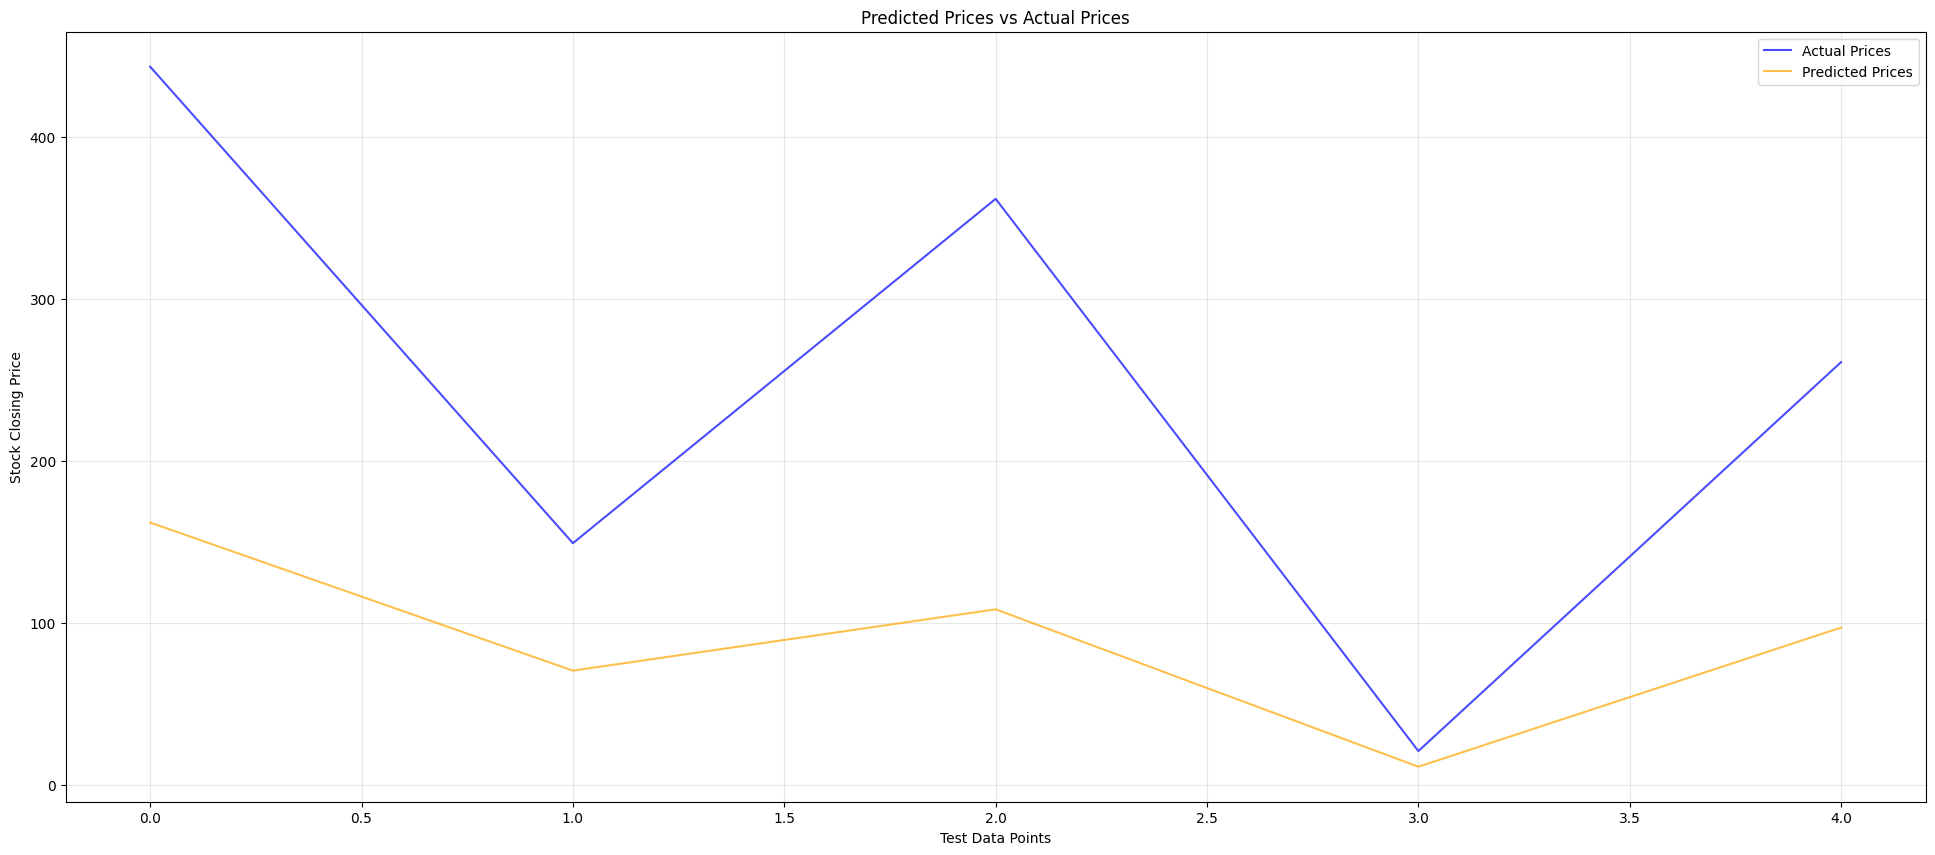

In [ ]:
import matplotlib.pyplot as plt

# Plot predicted vs actual prices for test data
plt.figure(figsize=(24, 10))
plt.plot(y_test, label="Actual Prices", color="blue", alpha=0.7)
plt.plot(predictions, label="Predicted Prices", color="orange", alpha=0.7)
plt.title("Predicted Prices vs Actual Prices")
plt.xlabel("Test Data Points")
plt.ylabel("Stock Closing Price")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import load_model

# Function to normalize data
def normalize_data(df, columns):
    scaler = MinMaxScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df, scaler

# Function for label encoding stock_id
def encode_stock_ids(df, column="stock_name"):
    le = LabelEncoder()
    df["stock_id_encoded"] = le.fit_transform(df[column])
    return df, le

# Prediction pipeline
def prediction_pipeline(stock_name, prediction_timeframe):
    # Predefined paths for the combined CSV and model
    combined_csv_path = '/content/gdrive/MyDrive/602_project/Combined_Testing_Data/updated_Testing_DataFile_with_stockid.csv'  # Set your combined CSV file path here
    model_path = '/content/gdrive/MyDrive/602_project/Testing_Stock_data/FinalStock_Trained_model.keras'  # Set your .keras model file path here

    # Load the trained model
    model = load_model(model_path)

    print("Model Summary:")
    model.summary()

    # Read the combined CSV data
    combined_df = pd.read_csv(combined_csv_path)

    # Encode stock IDs
    combined_df, le = encode_stock_ids(combined_df)

    # Ensure case-insensitivity for stock names
    stock_name = stock_name.upper()
    if stock_name not in combined_df["stock_name"].str.upper().unique():
        raise ValueError(f"Stock '{stock_name}' not found in dataset.")

    # Filter data for the selected stock
    df = combined_df[combined_df["stock_name"].str.upper() == stock_name].copy()

    # Normalize the relevant columns
    columns_to_normalize = ["open", "high", "low", "close", "volume", "rsi"]
    df, scaler = normalize_data(df, columns_to_normalize)

    # Extract encoded stock_id for the selected stock
    stock_id_encoded = le.transform([stock_name])[0]
    df["stock_id_encoded"] = stock_id_encoded

    # Get the last 60 days of data for predictions
    if len(df) < 60:
        raise ValueError(f"Not enough data for stock '{stock_name}'. At least 60 days of data is required.")

    last_60_days = df.tail(60)
    # Select only the columns expected by the model
    feature_columns = ["open", "high", "low", "close"]  # Ensure this matches the model input
    input_data = last_60_days[feature_columns].values

    # Expand dimensions for Keras model (batch size)
    input_data = np.expand_dims(input_data, axis=0)

    # Prepare stock_id input
    stock_id_input = np.array([stock_id_encoded]).reshape(1, 1)

    # Generate predictions
    predictions = []
    temp_data = input_data.copy()

    for _ in range(prediction_timeframe):
        pred = model.predict([temp_data, stock_id_input])
        predictions.append(pred[0, -1])  # Use the last prediction
        # Roll the data by removing the oldest and appending the prediction
        temp_data = np.roll(temp_data, -1, axis=1)
        temp_data[0, -1, 3] = pred[0, -1]  # Update "close" with the predicted price

    predictions = np.array(predictions)

    # Add predictions to the DataFrame
    df["Predicted Price"] = np.nan
    df.loc[df.index[-prediction_timeframe:], "Predicted Price"] = predictions

    return df, scaler, predictions

# Main function
if __name__ == "__main__":
    # User inputs for stock name and prediction timeframe
    stock_name = input("Enter stock name (e.g., CRM): ").strip()
    prediction_timeframe = int(input("Enter prediction timeframe (e.g., 7): "))

    # Run the prediction pipeline
    try:
        processed_df, scaler, predictions = prediction_pipeline(
            stock_name, prediction_timeframe
        )
    except Exception as e:
        print(f"Error: {e}")

Enter stock name (e.g., CRM): CRM
Enter prediction timeframe (e.g., 7): 7
Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ price_input (InputLayer)  │ (None, 60, 4)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stock_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 60, 32)         │          4,736 │ price_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 20)          │            460 │ stock_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 48)             │         15,552 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 20)             │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 68)             │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │          4,416 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32)             │          2,080 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │             33 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 81,833 (319.66 KB)

 Trainable params: 27,277 (106.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 54,556 (213.11 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


In [ ]:
import tensorflow as tf

# Prediction pipeline
def prediction_pipeline(stock_name, prediction_timeframe):
    # Predefined paths for the combined CSV and model
    combined_csv_path = '/content/gdrive/MyDrive/602_project/Combined_Testing_Data/updated_Testing_DataFile_with_stockid.csv'  # Set your combined CSV file path here
    model_path = '/content/gdrive/MyDrive/602_project/Testing_Stock_data/FinalStock_Trained_model.keras'  # Set your .keras model file path here

    # Load the trained model
    model = load_model(model_path)

    print("Model Summary:")
    model.summary()

    # Read the combined CSV data
    combined_df = pd.read_csv(combined_csv_path)

    # Encode stock IDs
    combined_df, le = encode_stock_ids(combined_df)

    # Ensure case-insensitivity for stock names
    stock_name = stock_name.upper()
    if stock_name not in combined_df["stock_name"].str.upper().unique():
        raise ValueError(f"Stock '{stock_name}' not found in dataset.")

    # Filter data for the selected stock
    df = combined_df[combined_df["stock_name"].str.upper() == stock_name].copy()

    # Normalize the relevant columns
    columns_to_normalize = ["open", "high", "low", "close", "volume", "rsi"]
    df, scaler = normalize_data(df, columns_to_normalize)

    # Extract encoded stock_id for the selected stock
    stock_id_encoded = le.transform([stock_name])[0]
    df["stock_id_encoded"] = stock_id_encoded

    # Get the last 60 days of data for predictions
    if len(df) < 60:
        raise ValueError(f"Not enough data for stock '{stock_name}'. At least 60 days of data is required.")

    last_60_days = df.tail(60)
    # Select only the columns expected by the model
    feature_columns = ["open", "high", "low", "close"]  # Ensure this matches the model input
    input_data = last_60_days[feature_columns].values

    # Expand dimensions for Keras model (batch size)
    input_data = np.expand_dims(input_data, axis=0)

    # Prepare stock_id input
    stock_id_input = np.array([stock_id_encoded]).reshape(1, 1)

    @tf.function
    def predict_single_step(model, price_input, stock_id_input):
        return model([price_input, stock_id_input])

    # Generate predictions
    predictions = []
    temp_data = input_data.copy()

    print(f"\nGenerating predictions for stock: {stock_name}, Timeframe: {prediction_timeframe} days\n")
    for day in range(1, prediction_timeframe + 1):
        pred = predict_single_step(model, temp_data, stock_id_input)
        predicted_price = pred[0, -1].numpy()  # Use the last prediction
        predictions.append(predicted_price)
        print(f"Day {day}: Predicted Price = {predicted_price:.2f}")
        # Roll the data by removing the oldest and appending the prediction
        temp_data = np.roll(temp_data, -1, axis=1)
        temp_data[0, -1, 3] = predicted_price  # Update "close" with the predicted price

    predictions = np.array(predictions)

    # Add predictions to the DataFrame
    df["Predicted Price"] = np.nan
    df.loc[df.index[-prediction_timeframe:], "Predicted Price"] = predictions

    return df, scaler, predictions

# Main function
if __name__ == "__main__":
    # User inputs for stock name and prediction timeframe
    stock_name = input("Enter stock name (e.g., CRM): ").strip()
    prediction_timeframe = int(input("Enter prediction timeframe (e.g., 7): "))

    # Run the prediction pipeline
    try:
        processed_df, scaler, predictions = prediction_pipeline(
            stock_name, prediction_timeframe
        )
    except Exception as e:
        print(f"Error: {e}")

Enter stock name (e.g., CRM): CRM
Enter prediction timeframe (e.g., 7): 7
Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ price_input (InputLayer)  │ (None, 60, 4)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stock_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 60, 32)         │          4,736 │ price_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 1, 20)          │            460 │ stock_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 48)             │         15,552 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 20)             │              0 │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 68)             │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │          4,416 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32)             │          2,080 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 1)              │             33 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 81,833 (319.66 KB)

 Trainable params: 27,277 (106.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 54,556 (213.11 KB)


Generating predictions for stock: CRM, Timeframe: 7 days

Day 1: Predicted Price = 509.78
Day 2: Predicted Price = 482.22
Day 3: Predicted Price = 486.93
Day 4: Predicted Price = 475.15
Day 5: Predicted Price = 471.45
Day 6: Predicted Price = 470.77
Day 7: Predicted Price = 471.60


Enter stock name (e.g., CRM): CRM
Enter prediction timeframe (e.g., 7): 7


<ipython-input-56-bf43a5d31b18>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Predicted Price"] = np.nan


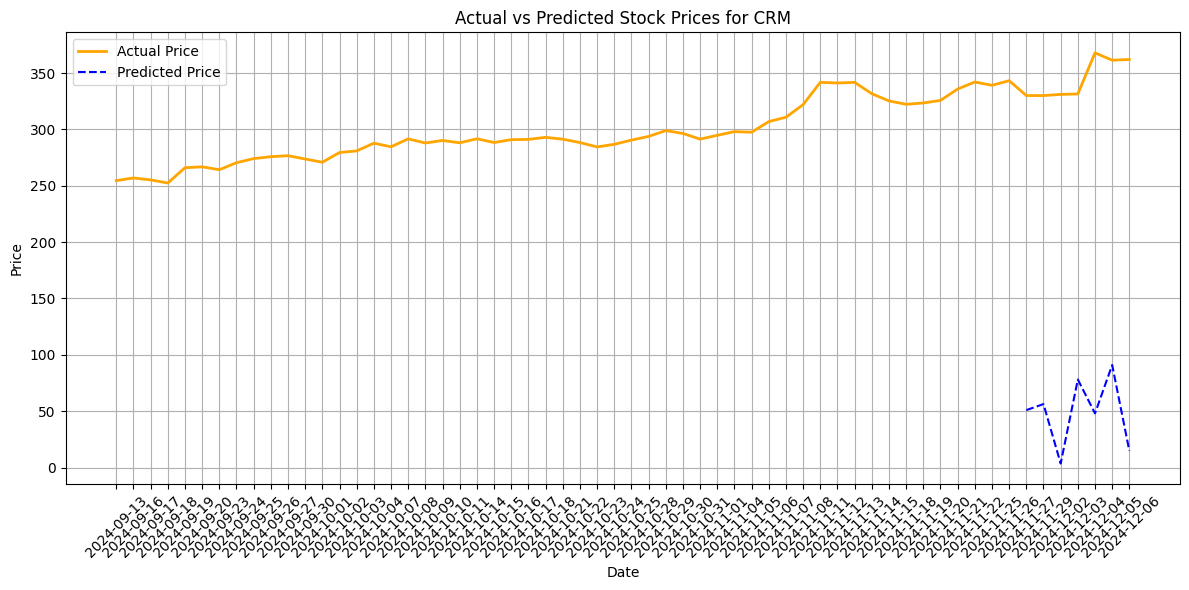

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(df, stock_name, predicted_prices, prediction_timeframe):
    # Ensure the 'Predicted Price' column is added to the dataframe using .loc
    df.loc[:, "Predicted Price"] = np.nan
    df.loc[df.index[-prediction_timeframe:], "Predicted Price"] = predicted_prices

    # Plotting the graph
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['close'], label="Actual Price", color="orange", linewidth=2)
    plt.plot(df['date'][-prediction_timeframe:], df['Predicted Price'][-prediction_timeframe:], label="Predicted Price", color="blue", linestyle="--")
    plt.title(f"Actual vs Predicted Stock Prices for {stock_name}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage of this function
def run_plotting(stock_name, prediction_timeframe):
    # Load the data for the selected stock
    df = pd.read_csv('/content/gdrive/MyDrive/602_project/Combined_Testing_Data/updated_Testing_DataFile_with_stockid.csv')  # Update the path to the dataset

    # Filter the data for the selected stock
    stock_data = df[df['stock_name'] == stock_name]

    # Assuming `predicted_prices` is the list of predicted prices
    predicted_prices = np.random.rand(prediction_timeframe) * 100  # Replace with actual predicted values

    # Plot the results
    plot_predictions(stock_data, stock_name, predicted_prices, prediction_timeframe)

# Running the example function with inputs
stock_name = input("Enter stock name (e.g., CRM): ")
prediction_timeframe = int(input("Enter prediction timeframe (e.g., 7): "))
run_plotting(stock_name, prediction_timeframe)